In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout
import pandas as pd

2024-07-03 00:06:27.658811: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 00:06:28.233600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 00:06:28.233656: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 00:06:28.335248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-03 00:06:28.542191: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_csv('./csv/clinical data.csv', sep=';')
df.head()

,NewPatientID,Sex,Age,weight (kg),T-Stage,N-Stage,M-Stage,Histopathological grading,Smoking History
0,A0001,M,58.0,65.0,2b,3,1b,G3,1
1,A0002,F,53.0,55.0,2b,1,0,NaN,0
2,A0003,M,60.0,62.0,1c,1,0,G3,0
3,A0004,F,48.0,56.0,1c,3,0,NaN,0
4,A0005,M,70.0,75.0,1b,0,0,G2,1


In [70]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
def dir_to_staging(img_dir, class_list, stage):
    arr = []
    data_dir = os.listdir(img_dir)
    data_dir.sort()
    for pict in data_dir:
        res = df[df["NewPatientID"].str.contains(pict[:5])]
        arr.append(class_list.index(str(res[stage+"-Stage"].values[0])[0]))
    res = to_categorical(arr, len(class_list))
    np_res = np.array(res)
    return np_res

In [4]:
from tensorflow.keras.preprocessing.image import load_img, random_rotation, random_shear, random_shift
import numpy as np
def img_loader(path):
    arr = []
    train_img_list = os.listdir(path)
    train_img_list.sort()
    # print(train_img_list)
    for pict in train_img_list:
        print('/'.join([path, pict]))
        img = load_img(path='/'.join([path, pict]), color_mode='rgb', target_size = (224, 223))
        img = np.array(img)
        img = random_rotation(img, 20)
        img = random_shear(img, 0.25)
        img = random_shift(img, 0.25, 0.25)
        arr.append(img)
    res = np.array(arr)
    return res

In [63]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def conf_matrix(x_test, y_test, model):
    y_true = []
    y_pred = []
    res = model.predict(x_test, verbose=0)
    for i in range(len(x_test)):
        y_true.append(np.argmax(y_test[i]))
        y_pred.append(np.argmax(res[i]))

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [12]:
# label staging
T = ["1", "2", "3", "4"]
N = ["0","1", "2", "3"]
M = ["0","1", "2"]

In [6]:
CHANNELS = 3

BATCH_SIZE = 32

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
HIDDEN_LAYER_ACTIVATION = 'relu'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

LOSS_METRICS = ['accuracy']

NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 10

BATCH_SIZE_TESTING = 1

In [7]:
src_path_train_tnm = "./Data_pet_CT_TNM/train/img"
src_path_valid_tnm = "./Data_pet_CT_TNM/valid/img"
src_path_test_tnm = "./Data_pet_CT_TNM/test/img"


X_train = img_loader(src_path_train_tnm)
X_valid = img_loader(src_path_valid_tnm)
X_test = img_loader(src_path_test_tnm)

./Data_pet_CT_TNM/train/img/A0001-1-13.png
./Data_pet_CT_TNM/train/img/A0001-1-14.png
./Data_pet_CT_TNM/train/img/A0001-1-15.png
./Data_pet_CT_TNM/train/img/A0001-1-16.png
./Data_pet_CT_TNM/train/img/A0001-1-17.png
./Data_pet_CT_TNM/train/img/A0001-1-18.png
./Data_pet_CT_TNM/train/img/A0001-1-19.png
./Data_pet_CT_TNM/train/img/A0001-1-20.png
./Data_pet_CT_TNM/train/img/A0002-1-09.png
./Data_pet_CT_TNM/train/img/A0002-1-10.png
./Data_pet_CT_TNM/train/img/A0002-1-11.png
./Data_pet_CT_TNM/train/img/A0002-1-12.png
./Data_pet_CT_TNM/train/img/A0002-1-13.png
./Data_pet_CT_TNM/train/img/A0002-1-14.png
./Data_pet_CT_TNM/train/img/A0002-1-15.png
./Data_pet_CT_TNM/train/img/A0003-1-12.png
./Data_pet_CT_TNM/train/img/A0003-1-13.png
./Data_pet_CT_TNM/train/img/A0003-1-14.png
./Data_pet_CT_TNM/train/img/A0004-1-07.png
./Data_pet_CT_TNM/train/img/A0004-1-08.png
./Data_pet_CT_TNM/train/img/A0004-1-09.png
./Data_pet_CT_TNM/train/img/A0004-1-10.png
./Data_pet_CT_TNM/train/img/A0005-1-11.png
./Data_pet_

## T staging

In [45]:
T_train = dir_to_staging(src_path_train_tnm, T, "T")
T_valid = dir_to_staging(src_path_valid_tnm, T, "T")
T_test = dir_to_staging(src_path_test_tnm, T, "T")

In [16]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dropout(0.5))
model.add(Dense(len(T), activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

2024-07-03 00:11:54.519368: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 00:11:54.796284: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 00:11:54.796328: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 00:11:54.797977: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 00:11:54.798009: I external/local_xla/xla/stream_executor

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 23604100 (90.04 MB)
Trainable params: 12292 (48.02 KB)
Non-trainable params: 23591808 (90.00 MB)
_________________________________________________________________


In [18]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [19]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
T_cb_checkpointer = ModelCheckpoint(filepath = './models/TNM/model-t.hdf5', monitor = 'val_loss', save_best_only = False, mode = 'auto')

In [20]:
fit_history = model.fit(
        x=X_train, 
        y=T_train,
        steps_per_epoch=int((len(X_train) / BATCH_SIZE)+1),
        epochs = NUM_EPOCHS,
        validation_data=(X_valid, T_valid),
        validation_steps=int((len(X_valid) / BATCH_SIZE)+1),
        callbacks=[
            # cb_early_stopper, 
            T_cb_checkpointer]
)

Epoch 1/50


2024-07-03 00:14:39.480716: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-07-03 00:14:39.912843: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-03 00:14:43.748941: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-03 00:14:44.027441: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc0fdb61790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-03 00:14:44.027470: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050, Compute Capability 8.6
I0000 00:00:1719940484.100139  189376 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26/26 [==============================] - ETA: 0s - loss: 1.0629 - accuracy: 0.6515

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 15s 329ms/step - loss: 1.0629 - accuracy: 0.6515 - val_loss: 1.3171 - val_accuracy: 0.5160
Epoch 2/50
26/26 [==============================] - 3s 130ms/step - loss: 0.2571 - accuracy: 0.9052 - val_loss: 0.8572 - val_accuracy: 0.6170
Epoch 3/50
26/26 [==============================] - 3s 128ms/step - loss: 0.0864 - accuracy: 0.9766 - val_loss: 0.5539 - val_accuracy: 0.7500
Epoch 4/50
26/26 [==============================] - 3s 127ms/step - loss: 0.0703 - accuracy: 0.9803 - val_loss: 0.4624 - val_accuracy: 0.8032
Epoch 5/50
26/26 [==============================] - 3s 127ms/step - loss: 0.0359 - accuracy: 0.9914 - val_loss: 0.4247 - val_accuracy: 0.8351
Epoch 6/50
26/26 [==============================] - 3s 127ms/step - loss: 0.0232 - accuracy: 0.9951 - val_loss: 0.3447 - val_accuracy: 0.8723
Epoch 7/50
26/26 [==============================] - 3s 128ms/step - loss: 0.0171 - accuracy: 0.9988 - val_loss: 0.2804 - val_accuracy: 0.9043
Epoch 8/50
26/26

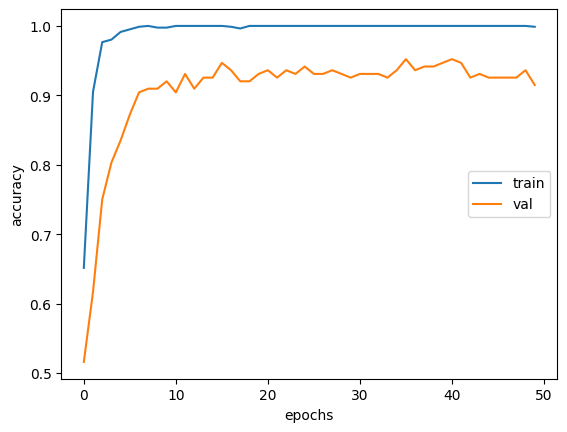

In [21]:
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

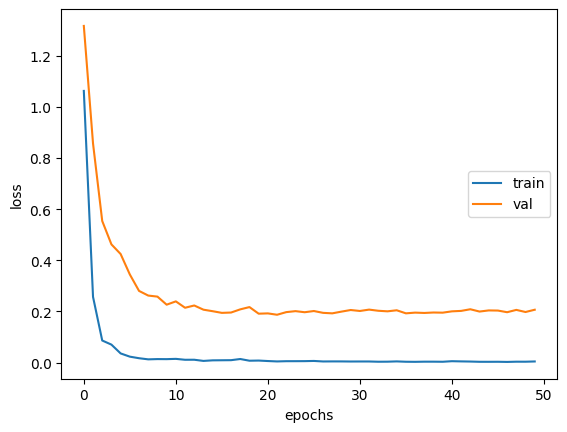

In [22]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [23]:
model.evaluate(x=X_test, y=T_test, batch_size=1)

92/92 [==============================] - 3s 15ms/step - loss: 0.2443 - accuracy: 0.9457


[0.24428358674049377, 0.945652186870575]

9/9 [==============================] - 1s 29ms/step
T stage prediction


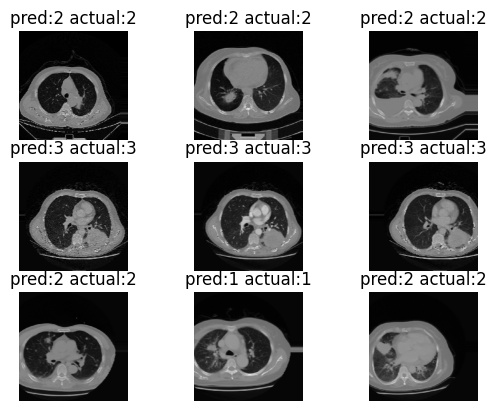

In [24]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("T stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+T[np.argmax(res[i])]+" actual:"+ T[np.argmax(T_test[i])])
    plt.axis('off')
plt.show()

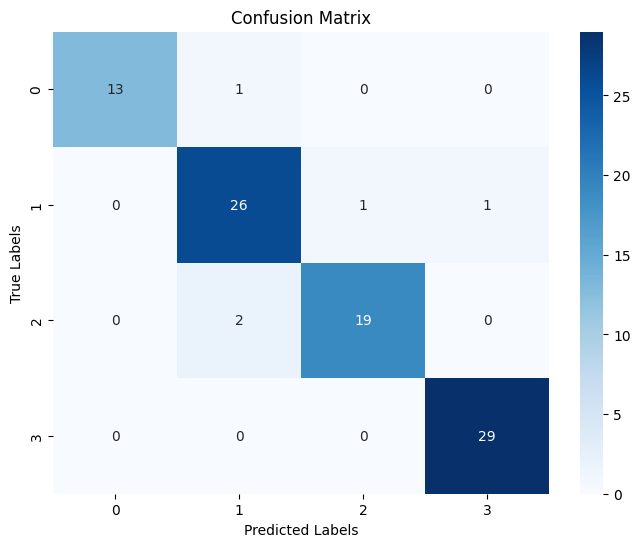

In [65]:
conf_matrix(X_test, T_test, model)

## N Staging

In [71]:
N_train = dir_to_staging(src_path_train_tnm, N, "N")
N_valid = dir_to_staging(src_path_valid_tnm, N, "N")
N_test = dir_to_staging(src_path_test_tnm, N, "N")

In [72]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dropout(0.5))
model.add(Dense(len(N), activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [73]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23604100 (90.04 MB)
Trainable params: 12292 (48.02 KB)
Non-trainable params: 23591808 (90.00 MB)
_________________________________________________________________


In [74]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [75]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
N_cb_checkpointer = ModelCheckpoint(filepath = './models/TNM/model-n.hdf5', monitor = 'val_loss', save_best_only = False, mode = 'auto')

In [76]:
fit_history = model.fit(
        x=X_train, 
        y=N_train,
        steps_per_epoch=int((len(X_train) / BATCH_SIZE)+1),
        epochs = NUM_EPOCHS,
        validation_data=(X_valid, N_valid),
        validation_steps=int((len(X_valid) / BATCH_SIZE)+1),
        callbacks=[
            # cb_early_stopper, 
            N_cb_checkpointer]
)

Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 1.1545 - accuracy: 0.6137

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 6s 143ms/step - loss: 1.1470 - accuracy: 0.6145 - val_loss: 1.1767 - val_accuracy: 0.5851
Epoch 2/50
26/26 [==============================] - 3s 118ms/step - loss: 0.2286 - accuracy: 0.9187 - val_loss: 0.9195 - val_accuracy: 0.6383
Epoch 3/50
26/26 [==============================] - 3s 117ms/step - loss: 0.0969 - accuracy: 0.9667 - val_loss: 0.8179 - val_accuracy: 0.7181
Epoch 4/50
26/26 [==============================] - 3s 117ms/step - loss: 0.0546 - accuracy: 0.9815 - val_loss: 0.3905 - val_accuracy: 0.8723
Epoch 5/50
26/26 [==============================] - 3s 115ms/step - loss: 0.0398 - accuracy: 0.9901 - val_loss: 0.3965 - val_accuracy: 0.8670
Epoch 6/50
26/26 [==============================] - 3s 120ms/step - loss: 0.0329 - accuracy: 0.9938 - val_loss: 0.3187 - val_accuracy: 0.8830
Epoch 7/50
26/26 [==============================] - 3s 115ms/step - loss: 0.0226 - accuracy: 0.9951 - val_loss: 0.2703 - val_accuracy: 0.9255
Epoch 8/50
26/26 

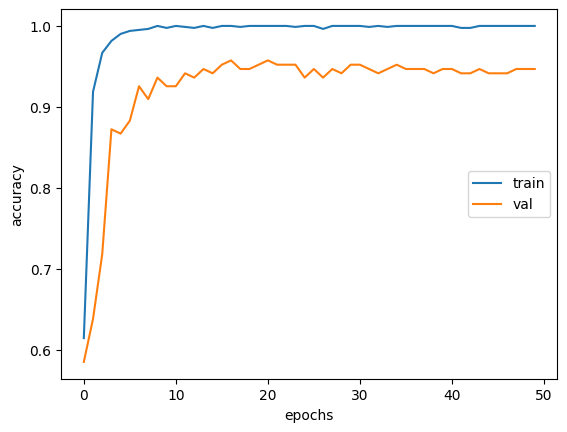

In [77]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

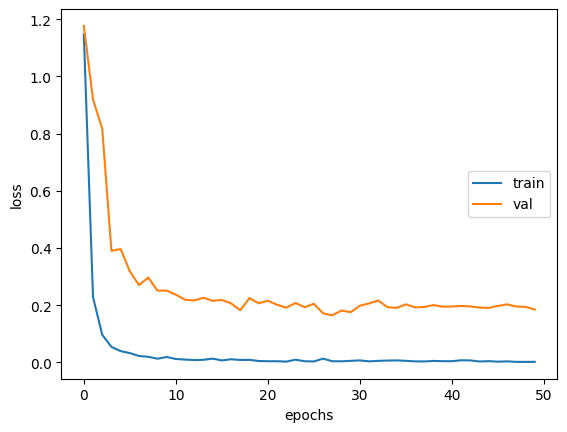

In [78]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [79]:
model.evaluate(x=X_test, y=N_test, batch_size=1)

92/92 [==============================] - 2s 15ms/step - loss: 0.1057 - accuracy: 0.9348


[0.10573643445968628, 0.9347826242446899]

9/9 [==============================] - 1s 12ms/step
N stage prediction


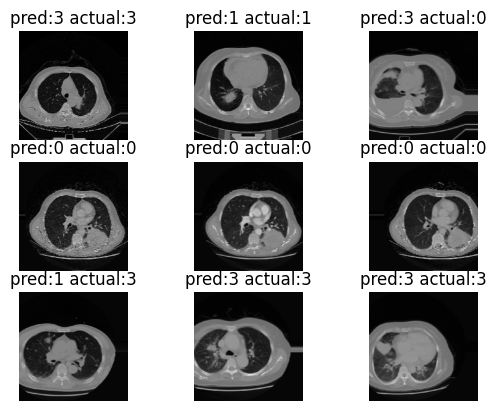

In [80]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("N stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+N[np.argmax(res[i])]+" actual:"+ N[np.argmax(N_test[i])])
    plt.axis('off')
plt.show()

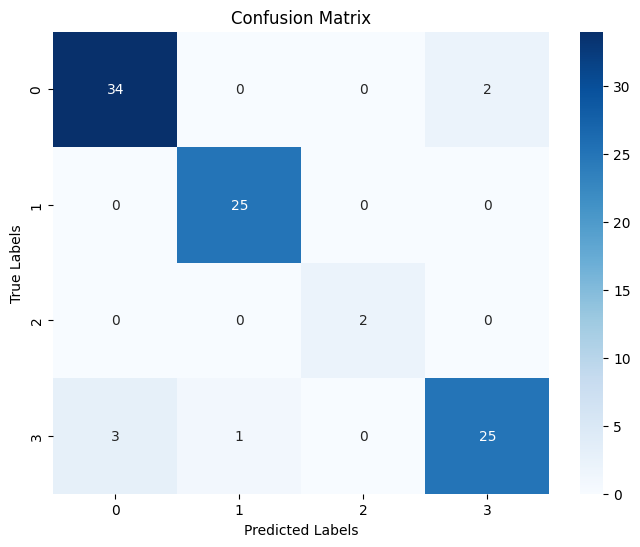

In [81]:
conf_matrix(X_test, N_test, model)

## M staging

In [82]:
M_train = dir_to_staging(src_path_train_tnm, M, "M")
M_valid = dir_to_staging(src_path_valid_tnm, M, "M")
M_test = dir_to_staging(src_path_test_tnm, M, "M")

In [83]:
model = Sequential()

model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))
model.add(Flatten())
model.add(BatchNormalization())


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(Dense(512, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(256, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dense(128, activation = HIDDEN_LAYER_ACTIVATION))
# model.add(Dropout(0.5))
model.add(Dense(len(M), activation = DENSE_LAYER_ACTIVATION))
# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_2 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 23602051 (90.03 MB)
Trainable params: 10243 (40.01 KB)
Non-trainable params: 23591808 (90.00 MB)
_________________________________________________________________


In [85]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [86]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
M_cb_checkpointer = ModelCheckpoint(filepath = './models/TNM/model-m.hdf5', monitor = 'val_loss', save_best_only = False, mode = 'auto')

In [87]:
fit_history = model.fit(
        x=X_train, 
        y=M_train,
        steps_per_epoch=int((len(X_train) / BATCH_SIZE)+1),
        epochs = NUM_EPOCHS,
        validation_data=(X_valid, M_valid),
        validation_steps=int((len(X_valid) / BATCH_SIZE)+1),
        callbacks=[
            # cb_early_stopper, 
            M_cb_checkpointer]
)

Epoch 1/50
25/26 [===========================>..] - ETA: 0s - loss: 0.9093 - accuracy: 0.6687

/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


26/26 [==============================] - 6s 136ms/step - loss: 0.9097 - accuracy: 0.6700 - val_loss: 0.8505 - val_accuracy: 0.6649
Epoch 2/50
26/26 [==============================] - 3s 119ms/step - loss: 0.2308 - accuracy: 0.9236 - val_loss: 0.4947 - val_accuracy: 0.8351
Epoch 3/50
26/26 [==============================] - 3s 116ms/step - loss: 0.1067 - accuracy: 0.9655 - val_loss: 0.4000 - val_accuracy: 0.8670
Epoch 4/50
26/26 [==============================] - 3s 117ms/step - loss: 0.0794 - accuracy: 0.9754 - val_loss: 0.2684 - val_accuracy: 0.9149
Epoch 5/50
26/26 [==============================] - 3s 120ms/step - loss: 0.0644 - accuracy: 0.9754 - val_loss: 0.2765 - val_accuracy: 0.9149
Epoch 6/50
26/26 [==============================] - 3s 120ms/step - loss: 0.0354 - accuracy: 0.9914 - val_loss: 0.2117 - val_accuracy: 0.9362
Epoch 7/50
26/26 [==============================] - 3s 117ms/step - loss: 0.0200 - accuracy: 0.9975 - val_loss: 0.1914 - val_accuracy: 0.9468
Epoch 8/50
26/26 

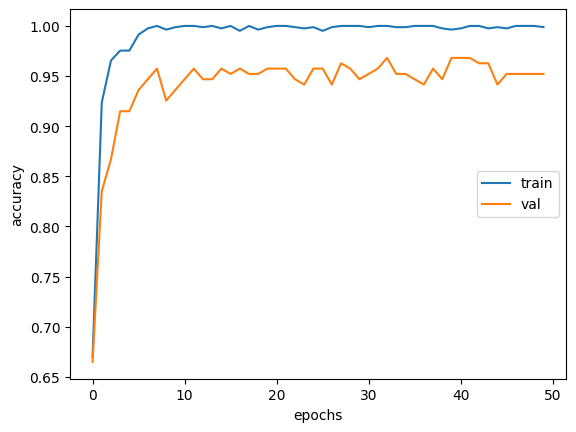

In [98]:
import matplotlib.pyplot as plt
plt.plot(fit_history.history['accuracy'], label = 'train',)
plt.plot(fit_history.history['val_accuracy'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

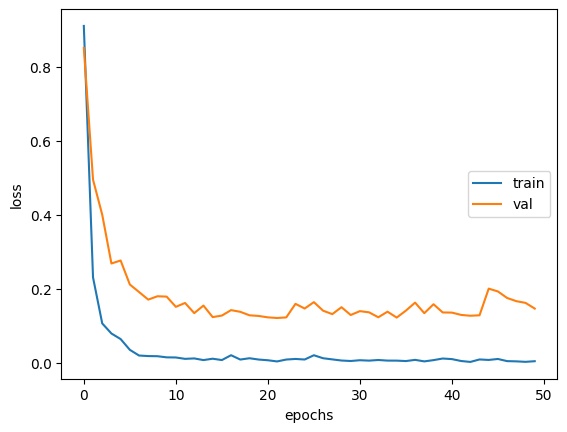

In [99]:
plt.plot(fit_history.history['loss'], label = 'train',)
plt.plot(fit_history.history['val_loss'], label = 'val')

plt.legend(loc = 'right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [100]:
model.evaluate(x=X_test, y=M_test, batch_size=1)

92/92 [==============================] - 2s 15ms/step - loss: 0.2373 - accuracy: 0.9239


[0.23729826509952545, 0.9239130616188049]

9/9 [==============================] - 0s 21ms/step
M stage prediction


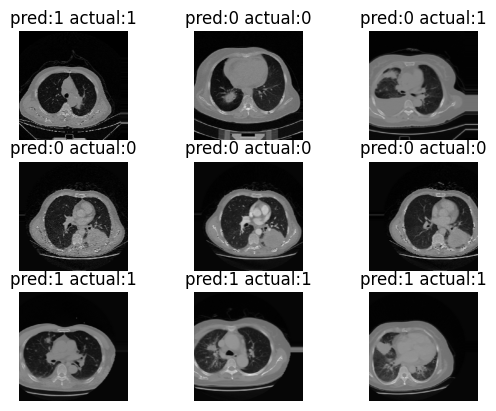

In [96]:
res = model.predict(X_test[:9], batch_size=1)

plt.figure()
print("M stage prediction")
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i])
    plt.title("pred:"+M[np.argmax(res[i])]+" actual:"+ M[np.argmax(M_test[i])])
    plt.axis('off')
plt.show()

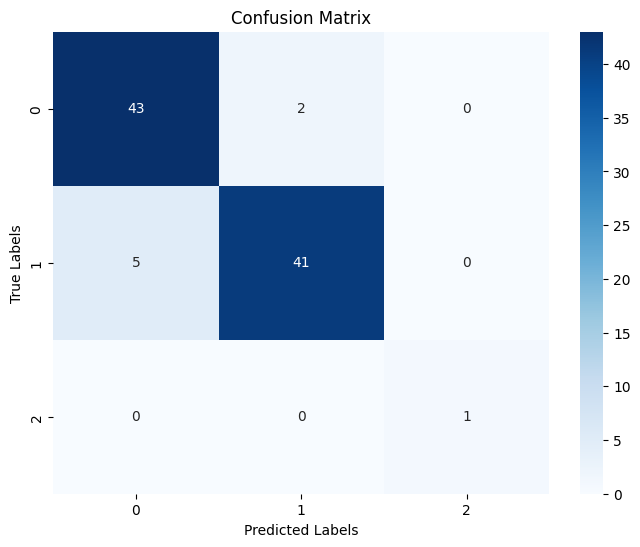

In [97]:
conf_matrix(X_test, M_test, model)